# Build genre dataset

This notebook documents the creation of the multi-genre dataset used in "Ascribing Historical Significance to Textual Similarity."

It begins with some exploration of the "subject" and "genre" fields in a deduplicated dataset of fiction in HathiTrust. The process of deduplication is more fully documented [in a different repository.](https://github.com/tedunderwood/noveltmmeta)

After surveying the landscape, I select certain subject and genre categories for the experiment. The sampling process is complicated, because I want to ensure that subsequent comparisons are able to compare non-overlapping sets.

Finally, HathiTrust metadata is used to define a rough measure of the social proximity between pairs of genres.

**Note to literary critics:** For the purpose of this experiment, I am *provisionally* borrowing the "subject" and "genre" categories librarians have used. A whole book could be written investigating the history of those categories, and arguing about their suitability. In other projects, I have used different genre definitions, borrowed from critics or bibliographers; in the future, I plan to use categories defined by the practice of book reviewers. The whole point of quantitative research on genre is that we don't have to be content with any particular set of categories, but are free to compare multiple perspectives.

In [73]:
import pandas as pd
import numpy as np
from collections import Counter
import random, csv

In [5]:
meta = pd.read_csv('../../noveltmmeta/workmeta.tsv', sep = '\t', low_memory = False)

### Find the most common genres

The status of genre in library metadata is somewhat vexed. I won't have space to explore the topic fully here, but readers should be aware of a few pitfalls.

For instance, genre categories were not systematically applied to library records until quite late in the 20th century. So our dataset contains many records, especially earlier records, that lack genre categories altogether. Moreover, specific categories often displace general ones. Don't be surprised, for instance, that in a dataset with more than 100,000 novels, only 3301 bear an explicit designation "Novel."

The metadata used here was originally contained in MARC records, and then transformed using [a script written by Ted Underwood and Michael L. Black.](https://github.com/tedunderwood/genredistance/blob/master/select_data/scrape_marc.py) Generally the genre tags reported below are drawn from MARC fields 655 or 155, and were originally chosen by catalogers from a list of [Library of Congress Genre / Form Terms.](https://www.loc.gov/catdir/cpso/genre_form_faq.pdf) However, a few of the larger categories below reflect information in the MARC header field. Some of these will seem paradoxical: for instance, why does a dataset of fiction contain 41,743 records tagged "Not Fiction"? That tag just reflects the absence of an explicit "fiction" marker in the header.

In [6]:
allgenres = Counter()
for idx, row in meta.iterrows():
    genres = row.genres
    if pd.isnull(genres):
        continue
    else:
        genres = genres.split('|')
    
    for g in genres:
        allgenres[g] += 1

In [4]:
genres = allgenres.most_common()
genres[0:75]

[('Fiction', 76816),
 ('NotFiction', 41743),
 ('UnknownGenre', 5845),
 ('Bibliographies', 4424),
 ('Novel', 3301),
 ('Juvenile audience', 3071),
 ('Short stories', 1332),
 ('Domestic fiction', 1117),
 ('Love stories', 980),
 ('Historical fiction', 950),
 ('Psychological fiction', 902),
 ('ContainsBiogMaterial', 889),
 ('Detective and mystery stories', 691),
 ('Mystery fiction', 658),
 ('Autobiography', 459),
 ('Science fiction', 376),
 ('Suspense fiction', 371),
 ('Biography', 297),
 ('NotBiographical', 290),
 ('Bildungsromans', 277),
 ("Publishers' advertisements", 275),
 ('Humorous stories', 229),
 ('Bildungsromane', 219),
 ('Adventure stories', 210),
 ('War stories', 207),
 ('Biographical fiction', 197),
 ('Humorous fiction', 185),
 ('Fantasy fiction', 185),
 ('Political fiction', 177),
 ('Mixed', 166),
 ('Western stories', 149),
 ('Fantastic fiction', 134),
 ('Juvenile literature', 124),
 ('Christian fiction', 124),
 ('Satire', 100),
 ('Horror fiction', 99),
 ('Juvenile works', 94)

[('Fiction', 27190),
 ('History', 5469),
 ('Social life and customs', 2876),
 ('English fiction', 2436),
 ('Translations into English', 2024),
 ('United States', 1894),
 ('20th century', 1727),
 ('Juvenile fiction', 1325),
 ('American fiction', 1270),
 ('World War, 1939-1945', 1222),
 ('Folklore', 1163),
 ('England', 1138),
 ('Women', 1102),
 ('Description and travel', 994),
 ('Tales', 851),
 ('World War, 1914-1918', 793),
 ('19th century', 770),
 ('Short stories, American', 706),
 ('Great Britain', 684),
 ('Short stories', 647),
 ('Short stories, English', 642),
 ('Juvenile literature', 623),
 ('English literature', 578),
 ('Indians of North America', 574),
 ('New York (State)', 567),
 ('Civil War, 1861-1865', 554),
 ('Man-woman relationships', 550),
 ('African Americans', 541),
 ('Gay men', 521),
 ('American literature', 521),
 ('California', 511),
 ('France', 499),
 ('Fairy tales', 455),
 ('New York', 437),
 ('Lesbians', 436),
 ('Women authors', 424),
 ('Science fiction, American', 

### Select groups of novels carrying specific genre tags

I select twenty genres, guided partly by an attempt to cover a range of different types of genres, and partly by a need to select genres with more than 100 examples in the dataset.

In some cases, I'm going to want to fold several different terms into a single category, so this is expressed as a dictionary where the key is a short term I plan to use, and the value is a set of terms I'll be fishing for in the dataset and equating to the key. In most cases, I think these decisions about synonymy are pretty transparent.

In [7]:
genre_categories = {'Novel': {'Novel'},
              'Juvenile': {'Juvenile audience'},
              'Short stories': {'Short stories'},
              'Domestic': {'Domestic fiction'},
              'Love': {'Love stories'},
              'Historical': {'Historical fiction'},
              'Psychological': {'Psychological fiction'},
              'Mystery': {'Detective and mystery stories', 'Mystery and detective fiction', 'Mystery fiction'},
              'Suspense': {'Suspense fiction'},
              'SF': {'Science fiction'},
              'Bildungsroman': {'Bildungsromans', 'Bildungsromane'},
              'Biographical': {'Biographical fiction'},
              'Humor': {'Humorous stories', 'Humorous fiction'},
              'Fantasy': {'Fantasy fiction', 'Fantastic fiction'},
              'Horror': {'Horror tales', 'Horror fiction', 'Occult fiction'},
              'Western': {'Western stories'},
              'Political': {'Political fiction'},
              'War': {'War stories'},
              'Adventure': {'Adventure stories', 'Adventure fiction'},
              'Christian': {'Christian fiction'}
             }

At this stage, we're not actually going to select specific examples of the genres. That needs to be done later, because I'm going to want to be able to guarantee that it's possible to compare genres and subjects to each other without overlap. So I need a complete list of genres, and a complete list of subjects, before selecting examples.

For right now, we simply iterate through the list of genre_categories and gather sets of matching volumes.

In [9]:
def hasgenre(row, genre2match):
    genres = row.genres
    date = row.inferreddate
    if pd.isnull(genres):
        return None
    elif pd.isnull(date) or int(date) < 1700:
        return None
    else:
        genres = genres.split('|')
        for g in genres:
            if g == genre2match:
                return row.docid
        return None

def gathergenre(genreset):
    global meta
    allmatches = set()
    for g in genreset:
        thisset = set(meta.apply(hasgenre, args = ([g]), axis = 1))
        thisset.remove(None)
        allmatches = allmatches.union(thisset)
    return allmatches     

In [10]:
category_dict = dict()

for name, category in categories.items(): 
    examples = gathergenre(category)
    category_dict[name] = examples

In [10]:
doublethese = {'Domestic', 'Historical', 'Mystery'}
genredist = dict()

def record_group(name, thesample):
    global datedist, genredist, meta
    print(name)
    subframe = meta.loc[meta.docid.isin(thesample), : ]
    print(len(subframe.inferreddate))
    print(np.mean(subframe.inferreddate))
    print()
    for idx, row in subframe.iterrows():
        date = int(row['inferreddate'])
        docid = row['docid']
        if docid not in genredist:
            genredist[docid] = {name}
        else:
            genredist[docid].add(name)

for name, category in categories.items(): 
    examples = gathergenre(category)
    chosen = random.sample(examples, 100)
    record_group(name, chosen)

    if name in doublethese:
        examples = list(set(examples) - set(chosen))
        secondgroup = random.sample(examples, 100)
        secondname = name + ' B'
        record_group(secondname, secondgroup)
        
    
    

Political
100
1986.42

War
100
1962.66

Mystery
100
1984.62

Mystery B
100
1991.93

Domestic
100
1993.38

Domestic B
100
1989.45

Bildungsroman
100
1981.58

Short stories
100
1983.42

SF
100
1988.16

Fantasy
100
1992.37

Horror
100
1989.91

Suspense
100
2004.96

Biographical
100
1987.94

Love
100
1986.77

Juvenile
100
1891.68

Psychological
100
1997.0

Humor
100
1991.95

Adventure
100
1978.05

Historical
100
1986.56

Historical B
100
1985.36

Western
100
1969.54



### most common subjects

Index terms contained in MARC fields 600-699 were counted as "subjects" if not specifically identified as "genre" terms or as "geographic" designations. Note that subject terms were added to MARC records several decades before genre terms came along. So in many 19c or early-20c records, things that we might consider genres are represented instead as subjects.

In [11]:
allsubjects = Counter()
for idx, row in meta.iterrows():
    genres = row.subjects
    if pd.isnull(genres):
        continue
    else:
        genres = genres.split('|')
    
    for g in genres:
        allsubjects[g] += 1

subjects = allsubjects.most_common()
subjects[0:100]

[('Fiction', 27190),
 ('History', 5469),
 ('Social life and customs', 2876),
 ('English fiction', 2436),
 ('Translations into English', 2024),
 ('United States', 1894),
 ('20th century', 1727),
 ('Juvenile fiction', 1325),
 ('American fiction', 1270),
 ('World War, 1939-1945', 1222),
 ('Folklore', 1163),
 ('England', 1138),
 ('Women', 1102),
 ('Description and travel', 994),
 ('Tales', 851),
 ('World War, 1914-1918', 793),
 ('19th century', 770),
 ('Short stories, American', 706),
 ('Great Britain', 684),
 ('Short stories', 647),
 ('Short stories, English', 642),
 ('Juvenile literature', 623),
 ('English literature', 578),
 ('Indians of North America', 574),
 ('New York (State)', 567),
 ('Civil War, 1861-1865', 554),
 ('Man-woman relationships', 550),
 ('African Americans', 541),
 ('Gay men', 521),
 ('American literature', 521),
 ('California', 511),
 ('France', 499),
 ('Fairy tales', 455),
 ('New York', 437),
 ('Lesbians', 436),
 ('Women authors', 424),
 ('Science fiction, American', 

In [42]:
subjects2find = {'Subj: Detective': {'Women detectives', 'Detective and mystery stories', 'Detective stories', 
                                     'Mystery and detective stories', 'Detective and mystery stories, French', 
                                     'Detective and mystery stories, New Zealand', 'Detective and mystery stories, Danish', 
                                     'Detective and mystery stories, Scottish', 'Detective and mystery stories, English', 
                                     'Detective and mystery stories, American'},
                 'Subj: Man-woman': {'Man-woman relationships', 'Marriage'}, 
                 'Subj: SF, Other': {'Science fiction, French', 'Science fiction, Canadian', 
                              'Science fiction, Polish', 'Science fiction, Australian', 
                              'Science fiction, Russian', 'Science fiction, English', 
                              'Science fiction'},
                 'Subj: SF, American': {'Science fiction, American'},
                 'Subj: Short stories, Other': {'Short stories, Icelandic', 'Short stories, Nepali',
                                                'Short stories, Serbian', 'Short stories, Turkish', 
                                                'Short stories, Ghanaian (English)', 'Short stories, Indic (English)',
                                                'Short stories in Russian, 1917-1945 - English texts', 
                                                'Short stories in French, 1900-1945 - English texts', 
                                                'Short stories, Ukrainian', 'Short stories, Caribbean (English)', 
                                                'Short stories, Sindhi', 'Short stories, Urdu', 'Short stories, Arabic', 
                                                'Short stories, Vietnamese', 'Short stories, Lithuanian', 
                                                'Short stories, African (English)', 'Short stories, Malaysian', 
                                                'Short stories, Australian', 'Short stories, Pakistani', 
                                                'Short stories, Irish', 'Short stories, South African (English)', 
                                                'Short stories, Bulgarian', 'Short stories, Panjabi', 
                                                'Short stories, Canadian', 'Short stories, New Zealand', 
                                                'Short stories, Norwegian', 'Short stories, Dutch', 
                                                'Short stories, Malay', 'Short stories, Tarascan', 
                                                'Short stories, English', 'Short stories, South African'},
                 'Subj: Short stories, American': {'Short stories, American'},
                 'Subj: Fairy tales': {'Fairy tales, American', 'Fairy tales, Scottish',
                                       'Fairy tales.', 'Fairy tales, Japanese', 
                                       'Fairy tales, German', 'Fairy tales, English', 
                                       'Fairy tales, French', 'Fairy tales'}, 
                 "Subj: Fantasy": {'Fantasy fiction, Scottish', 'Fantasy games', 'Fantasy fiction, Chinese',
                                   'Fantasy', 'Fantasy fiction, Yiddish', 'Fantasy fiction, French', 
                                   'Fantasy fiction', 'Fantasy fiction, Russian', 'Fantasy fiction, English',
                                   'Fantasy fiction, American', 'Fantasy fiction, Romanian'},
                 'Subj: Horror': {'Horror short stories in English, 1837-1945 - Anthologies', 
                                  'Horror tales, Singaporean', 'Horror & ghost stories', 'Horror tales',
                                  'Horror tales, Irish',  'Horror tales, American', 'Horror tales, Scottish',
                                  'Horror stories', 'Horror tales, Canadian', 'Horror tales, English',
                                  'Ghost stories', 'Ghosts'},
                 'Subj: History': {'History'},
                 'Subj: Humor': {'English wit and humor', 'Humor',
                          'American wit and humor', 'Humorous stories, American', 'Humorous stories'}
                }

In [37]:
def hassubject(row, subj2match):
    ''' A little different from hasgenre, because it's looking
    for a phrase *in* a subject rather than attempting an exact
    match.
    '''
    subjects = row.subjects
    if pd.isnull(subjects) or pd.isnull(row.inferreddate):
        return None
    elif int(row.inferreddate) < 1700 or int(row.inferreddate) > 1979:
        return None
    else:
        subjects = subjects.split('|')
        for s in subjects:
            if s in subj2match:
                return row.name
        
    return None

def gathersubject(subj):
    global meta
    allmatches = set()
    thisset = set(meta.apply(hassubject, args = ([subj]), axis = 1))
    thisset.remove(None)
    return thisset  

In [45]:
for name, category in subjects2find.items():
    print(name)
    examples = gathersubject(category)
    category_dict[name] = examples

Subj: Humor
Subj: Short stories, Other
Subj: History
Subj: SF, Other
Subj: Fairy tales
Subj: Fantasy
Subj: Short stories, American
Subj: Detective
Subj: SF, American
Subj: Man-woman
Subj: Horror


In [75]:
with open('summary_of_available_genres.tsv', mode = 'w', encoding = 'utf-8') as f:
    writer = csv.DictWriter(f, delimiter = '\t', fieldnames = ['genre', 'numvols', 'meandate'])
    writer.writeheader()
    for catname, examples in category_dict.items():
        dates = meta.loc[examples, 'inferreddate']
        print(catname, '  |  ', len(examples), '  |  ', round(np.mean(dates), 2))
        outrow = dict()
        outrow['genre'] = catname
        outrow['numvols'] = len(examples)
        outrow['meandate'] = round(np.mean(dates), 2)
        writer.writerow(outrow)

Bildungsroman   |   490   |   1985.69
Subj: Humor   |   353   |   1903.17
Love   |   980   |   1982.12
Novel   |   3301   |   1985.96
Domestic   |   1117   |   1992.33
Subj: Detective   |   258   |   1943.84
Mystery   |   1377   |   1986.73
Subj: Man-woman   |   251   |   1927.22
Western   |   149   |   1970.6
Suspense   |   371   |   2003.47
Christian   |   124   |   1975.17
Humor   |   406   |   1991.66
Horror   |   205   |   1989.45
Political   |   177   |   1985.12
War   |   207   |   1967.19
Subj: Fairy tales   |   386   |   1908.9
Juvenile   |   3071   |   1894.53
Biographical   |   197   |   1988.79
Fantasy   |   317   |   1992.12
Psychological   |   902   |   1996.89
Subj: Horror   |   162   |   1938.2
Subj: Fantasy   |   112   |   1944.01
Subj: Short stories, American   |   322   |   1937.2
Historical   |   950   |   1986.11
Short stories   |   1332   |   1985.43
Subj: Short stories, Other   |   457   |   1949.29
Subj: History   |   3582   |   1903.28
SF   |   375   |   1988.1

So, we've got 31 categories. Complemented with "random," we can call it a round 32.

### Selecting examples of the categories

**Basic samples.** First, we simply select 102 random examples of each category. (We're going to use 100-text samples, but it's wise to leave a little extra room in case one text turns out to be defective / missing.)

**Intersectional samples.** But we also want to be able to ensure non-overlapping comparisons if needed. So we also compare each category to all the others, and where there are intersections, we create extra categories like

    Horror-Not-Humor

With enough extra volumes to ensure non-overlap.

**B samples.**

In genres where we have enough examples to go around, we also create a second "B sample," to permit self-comparison. These have to be non-overlapping with the A sample, but we don't do the whole intersectional song and dance for the B samples.

In [61]:
genredist = dict()

def get_pure_examples(catname1, catname2, catset1, catset2, category_dict, overlaplen):
    only1 = category_dict[catname1] - category_dict[catname2]
    # Let's sample from examples of category 1 known not to be in
    # category 2
    
    only1 = only1 - catset1
    # Because these are supposed to be additional examples, not ones
    # already in the category
    
    onenottwo = random.sample(only1, overlaplen)
    return onenottwo

# first, we select the basic genre samples

for catname, examples in category_dict.items():
    
    chosen = random.sample(examples, 102)
    genredist[catname] = set(chosen)
        
print()
print('Basic samples selected.')
print()
print('Intersectional samples:')
print('-----------------------')

# then create special intersectional categories
# to permit non-overlapping comparisons

toadd = dict()
for g1, gset1 in genredist.items():
    for g2, gset2 in genredist.items():
        if g1 == g2:
            continue
        
        overlap = len(gset1.intersection(gset2))
        if overlap > 0:
            print(g1, g2, overlap)
            only1 = get_pure_examples(g1, g2, gset1, gset2, category_dict, overlap)
            name1not2 = g1 + '-Not-' + g2
            toadd[name1not2] = only1
            
            only2 = get_pure_examples(g2, g1, gset2, gset1, category_dict, overlap)
            name2not1 = g2 + '-Not-' + g1
            toadd[name2not1] = only2

for key, value in toadd.items():
    genredist[key] = value
    
print()            
print('Intersectional samples selected.')
print()
print('B samples:')
print('----------')
# Then we select "B" samples in cases where there are enough instances
# to make this practical.

for catname, examples in category_dict.items():
    
    chosen = genredist[catname]
    
    if len(examples) > 300:
        remainder = examples - set(chosen)
        nameB = catname + ' B'
        chosenB = random.sample(remainder, 102)
        genredist[nameB] = chosenB
        print(nameB)


Basic samples selected.

Intersectional samples:
-----------------------
Bildungsroman Western 2
Bildungsroman Christian 1
Bildungsroman Humor 2
Bildungsroman War 1
Bildungsroman Juvenile 1
Bildungsroman Fantasy 1
Bildungsroman Historical 1
Bildungsroman Domestic 1
Bildungsroman Adventure 2
Subj: Humor Subj: Man-woman 1
Love Subj: Man-woman 2
Love Christian 5
Love Political 1
Love Biographical 1
Love Historical 1
Love Domestic 1
Novel Western 1
Novel Mystery 1
Novel Suspense 1
Novel War 2
Novel Psychological 1
Novel Historical 1
Novel Subj: SF, American 1
Western Bildungsroman 2
Western Novel 1
Western Subj: Man-woman 1
Western War 2
Western Biographical 3
Western Domestic 2
Western Short stories 1
Subj: Detective Juvenile 1
Subj: Detective Subj: Horror 1
Mystery Novel 1
Mystery Suspense 1
Mystery Psychological 1
Subj: Man-woman Subj: Humor 1
Subj: Man-woman Love 2
Subj: Man-woman Western 1
Subj: Man-woman Psychological 1
Subj: Man-woman Domestic 1
Subj: Man-woman Adventure 1
Suspense

In [62]:
allvols = set()
for name, genreset in genredist.items():
    allvols = allvols.union(genreset)
print(len(allvols))

4904


### Exploratory analysis of selected volumes

Just to get a sense of what we're looking at.

The cell immediately below also importantly creates the dictionary ```genresfordocs```, which will be used a lot below. This is a dict where each key is a volume ID and the value is a set of genre tags possessed by the volume.

In [63]:
# Now let's get a sense of how these volumes are distributed on the timeline
genresfordocs = dict()
for genrename, docsingenre in genredist.items():
    for docid in docsingenre:
        if docid not in genresfordocs:
            genresfordocs[docid] = set()
        genresfordocs[docid].add(genrename)

datedist = Counter()
datebygenre = dict()
allgenrenames = set()

for docid, genreset in genresfordocs.items():
    date = int(meta.loc[docid, 'inferreddate'])
    datedist[date] += 1
    for g in genreset:
        allgenrenames.add(g)
        if g not in datebygenre:
            datebygenre[g] = Counter()
        datebygenre[g][date] += 1

print(len(datedist))
print(sum(datedist.values()))
print()

maxforyear = dict()
for d in datedist.keys():
    maximum = 0
    for g in allgenrenames:
        if datebygenre[g][d] > maximum:
            maximum = datebygenre[g][d]
    maxforyear[d] = maximum
print(sum(maxforyear.values()))  

210
4904

744


#### maximum number of vols in a year

This is not all the volumes, but just the maximum in any single genre. It's an important figure because we're going to use this to guarantee that our random datasets have enough volumes to create a date-matching contrast set for any genre.

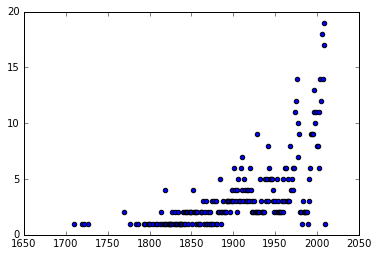

In [64]:
from matplotlib import pyplot as plt
%matplotlib inline

x = []
y = []
for date, count in maxforyear.items():
    x.append(date)
    y.append(count)

plt.scatter(x, y)

#### all vols in a year

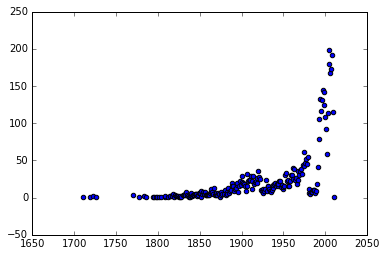

In [65]:
from matplotlib import pyplot as plt
%matplotlib inline

x = []
y = []
for date, count in datedist.items():
    x.append(date)
    y.append(count)

plt.scatter(x, y)

1979


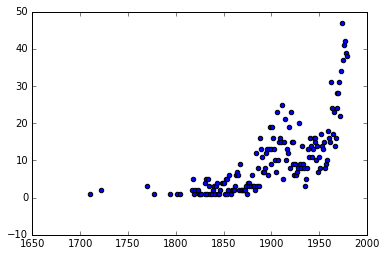

In [83]:
# now only for "subjects"

subjdatedist = Counter()

for docid, genreset in genresfordocs.items():
    date = int(meta.loc[docid, 'inferreddate'])
    for g in genreset:
        if g.startswith('Subj:'):
            subjdatedist[date] += 1
            break

x = []
y = []
for date, count in subjdatedist.items():
    x.append(date)
    y.append(count)

plt.scatter(x, y)
print(np.amax(list(subjdatedist.keys())))

### Gather random contrast sets

We gather two contrast sets. (Some predictive modeling we do is going to require that a model trained on contrast set A be applied to a non-overlapping set B.)

Note however that we do *not* ensure the sets are non-overlapping with our genre sets. That would create a selection bias. Later on, we can select *within* randomA or randomB to get a negative set that matches a given positive set by date and doesn't overlap with it.

In [70]:
# let's get random fiction that roughly matches that date distribution

chosenrandomA = []
chosenrandomB = []

for date, count in maxforyear.items():
    candidates = meta.loc[meta.inferreddate == date, : ]
    eligible_indices = candidates.index.tolist()
    choiceA = random.sample(eligible_indices, count)
    eligible_indices = list(set(eligible_indices) - set(choiceA))
    if len(eligible_indices) < count:
        print("error, running dry")
        break
    else:
        choiceB = random.sample(eligible_indices, count)
    
    chosenrandomA.extend(choiceA)
    chosenrandomB.extend(choiceB)
        
print(len(chosenrandomA))

744


In [71]:
# integrate the random choices into genresfordocs:
print(len(genresfordocs))

for docid in chosenrandomA:
    if docid not in genresfordocs:
        genresfordocs[docid] = {'randomA'}
    else:
        genresfordocs[docid].add('randomA')

for docid in chosenrandomB:
    if docid not in genresfordocs:
        genresfordocs[docid] = {'randomB'}
    else:
        genresfordocs[docid].add('randomB')

print(len(genresfordocs))

4904
6307


Write the sizes and mean dates of genres as selected. We might need this later.

In [84]:
with open('../metadata/selected_genres.tsv', mode = 'w', encoding = 'utf-8') as f:
    writer = csv.DictWriter(f, delimiter = '\t', fieldnames = ['genre', 'numvols', 'meandate'])
    writer.writeheader()
    for genrename, examples in genredist.items():
        dates = meta.loc[examples, 'inferreddate']
        outrow = dict()
        outrow['genre'] = genrename
        outrow['numvols'] = len(examples)
        outrow['meandate'] = round(np.mean(dates), 2)
        writer.writerow(outrow)
    examples = chosenrandomA
    dates = meta.loc[examples, 'inferreddate']
    outrow = dict()
    outrow['genre'] = 'randomA'
    outrow['numvols'] = len(examples)
    outrow['meandate'] = round(np.mean(dates), 2)
    writer.writerow(outrow)
    examples = chosenrandomB
    dates = meta.loc[examples, 'inferreddate']
    outrow = dict()
    outrow['genre'] = 'randomB'
    outrow['numvols'] = len(examples)
    outrow['meandate'] = round(np.mean(dates), 2)
    writer.writerow(outrow)
    
    

### Actually write the main metadata to disk.

In [85]:
# okay, now let's write the thing

allchosen = list(genresfordocs.keys())

chosendf = meta.loc[allchosen, ['author', 'shorttitle', 'enumcron', 'inferreddate', 'genres', 'subjects', 'allcopiesofwork']]

In [86]:
chosendf.shape

(6307, 7)

In [87]:
# Create a column for the genre tags.

def mygenres(idx):
    global genresfordocs
    if idx not in genresfordocs:
        print("ERROR")
        return float('nan')
    else:
        return '|'.join(genresfordocs[idx])

chosendf = chosendf.assign(tags = chosendf.index.map(mygenres))

In [89]:
chosendf.rename(index=str, columns={"inferreddate": "firstpub"}, inplace = True)

# No, these are not really dates of first publication. But my modeling code has
# evolved to use 'firstpub' as a default term and I don't want to fiddle with it.

In [90]:
chosendf.head()

,author,shorttitle,enumcron,firstpub,genres,subjects,allcopiesofwork,tags
docid,,,,,,,,
uc1.32106018766995,"Munro, Alice",Away from her,NaN,2007,Love stories|Fiction,Marriage|Fiction|Alzheimer's disease|College t...,1,Love B
uc2.ark+=13960=t15m64w2c,NaN,Stories by English authors,v.10,1900,NaN,"Short stories, English",2,"Subj: Short stories, Other B"
uc1.b4538430,"Zangwill, Israel",Selected works of Israel Zangwill: Children of...,NaN,1938,Fiction,London|England|Fiction|Jews,2,randomB
uc2.ark+=13960=t50g3mg58,"Safroni-Middleton, A (Arnold)",South Sea foam,NaN,1919,NaN,Folklore|Polynesia,1,randomA
osu.32435063107270,"Haskin, Dorothy C",The heart's highest hurdle : a novel of the Ol...,NaN,1960,Fiction|Christian fiction,NaN,1,Christian-Not-Love|Christian-Not-Biographical


In [91]:
chosendf.to_csv('../metadata/newgenremeta.csv')

In [32]:
categories


{'Adventure': {'Adventure fiction', 'Adventure stories'},
 'Bildungsroman': {'Bildungsromane', 'Bildungsromans'},
 'Biographical': {'Biographical fiction'},
 'Domestic': {'Domestic fiction'},
 'Fantasy': {'Fantastic fiction', 'Fantasy fiction'},
 'Historical': {'Historical fiction'},
 'Horror': {'Horror fiction', 'Horror tales', 'Occult fiction'},
 'Humor': {'Humorous fiction', 'Humorous stories'},
 'Juvenile': {'Juvenile audience'},
 'Love': {'Love stories'},
 'Mystery': {'Detective and mystery stories',
  'Mystery and detective fiction',
  'Mystery fiction'},
 'Political': {'Political fiction'},
 'Psychological': {'Psychological fiction'},
 'SF': {'Science fiction'},
 'Short stories': {'Short stories'},
 'Suspense': {'Suspense fiction'},
 'War': {'War stories'},
 'Western': {'Western stories'}}

In [43]:
doublethese = {'Domestic', 'Historical', 'Mystery'}
genrecategories = dict()
for name, cat in categories.items():
    genrecategories[name] = cat
    if name in doublethese:
        genrecategories[name + ' B'] = cat

In [48]:
for name, category in subjects2find.items():
    name = 'Subject: ' + name
    print(name)
    examples = gathersubject(category)
    genresets[name] = examples
    genrecategories[name] = category
    

Subject: Man-woman
Subject: Short stories
Subject: Fantasy
Subject: Children's literature
Subject: Detective
Subject: Science fiction
Subject: Fairy tales


In [61]:
overlap = {'Subject: Man-woman': {'Love': 0.4}, 'Subject: Short stories': {'Short stories': 0.6}, 
           'Subject: Fantasy': {'Fantasy': 0.6}, "Subject: Children's literature": {'Juvenile': 0.4},
          'Subject: Science fiction': {'SF': 0.6}, 'Subject: Fairy tales': {'Juvenile': 0.3},
          'Subject: Detective': {'Mystery': 0.4}}

In [56]:
# genresets = dict()

jaccard = dict()
for name, category in genrecategories.items(): 
    print(name)
    for name2, category2 in genrecategories.items():
        if name in genresets:
            ex1 = genresets[name]
        elif name.startswith('Subj'):
            ex1 = set(gathersubject(category))
            genresets[name] = ex1
        else:
            ex1 = set(gathergenre(category))
            genresets[name] = ex1
        
        if name2 in genresets:
            ex2 = genresets[name2]
        elif name2.startswith('Subj'):
            ex2 = set(gathersubject(category2))
            genresets[name2] = ex2
        else:
            ex2 = set(gathergenre(category2))
            genresets[name2] = ex2
        inter = len(ex1.intersection(ex2))
        union = len(ex1.union(ex2))
        
        if name in overlap and name2 in overlap[name]:
            inter = inter + overlap[name][name2] * union
        elif name2 in overlap and name in overlap[name2]:
            inter = inter + overlap[name2][name] * union
        
        j = inter / union
        
        if name not in jaccard:
            jaccard[name] = dict()
        jaccard[name][name2] = j
        
jacdf = pd.DataFrame(jaccard)
jacdf

War
Mystery
Bildungsroman
Short stories
Domestic B
Fantasy
Horror
Historical B
Subject: Man-woman
Biographical
Love
Juvenile
Subject: Detective
Humor
Adventure
Subject: Fairy tales
Political
Domestic
Subject: Science fiction
Western
SF
Subject: Children's literature
Suspense
Psychological
Subject: Short stories
Mystery B
Subject: Fantasy
Historical


,Adventure,Bildungsroman,Biographical,Domestic,Domestic B,Fantasy,Historical,Historical B,Horror,Humor,...,Subject: Children's literature,Subject: Detective,Subject: Fairy tales,Subject: Fantasy,Subject: Man-woman,Subject: Science fiction,Subject: Short stories,Suspense,War,Western
Adventure,1.000000,0.014342,0.004141,0.005727,0.005727,0.021959,0.026534,0.026534,0.000000,0.019090,...,0.002299,0.001779,0.000000,0.000000,0.004184,0.002959,0.000627,0.003044,0.008147,0.004598
Bildungsroman,0.014342,1.000000,0.000000,0.070620,0.070620,0.001241,0.023454,0.023454,0.002886,0.028703,...,0.000000,0.000000,0.000000,0.000000,0.007386,0.000000,0.000000,0.004667,0.017518,0.011076
Biographical,0.004141,0.000000,1.000000,0.001524,0.001524,0.000000,0.048446,0.048446,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012531,0.032836
Domestic,0.005727,0.070620,0.001524,1.000000,1.000000,0.000698,0.045524,0.045524,0.002274,0.024899,...,0.000000,0.000000,0.000000,0.000000,0.010031,0.000000,0.000000,0.008814,0.009916,0.006359
Domestic B,0.005727,0.070620,0.001524,1.000000,1.000000,0.000698,0.045524,0.045524,0.002274,0.024899,...,0.000000,0.000000,0.000000,0.000000,0.010031,0.000000,0.000000,0.008814,0.009916,0.006359
Fantasy,0.021959,0.001241,0.000000,0.000698,0.000698,1.000000,0.020951,0.020951,0.039841,0.009777,...,0.002155,0.000000,0.000000,0.507042,0.001969,0.000000,0.000616,0.005848,0.005758,0.000000
Historical,0.026534,0.023454,0.048446,0.045524,0.045524,0.020951,1.000000,1.000000,0.004348,0.006682,...,0.000000,0.000000,0.000000,0.000000,0.004398,0.000000,0.000000,0.009939,0.073284,0.015712
Historical B,0.026534,0.023454,0.048446,0.045524,0.045524,0.020951,1.000000,1.000000,0.004348,0.006682,...,0.000000,0.000000,0.000000,0.000000,0.004398,0.000000,0.000000,0.009939,0.073284,0.015712
Horror,0.000000,0.002886,0.000000,0.002274,0.002274,0.039841,0.004348,0.004348,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006993,0.000000,0.005682
Humor,0.019090,0.028703,0.000000,0.024899,0.024899,0.009777,0.006682,0.006682,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.001675,0.000000,0.000000,0.003876,0.000000,0.000000


In [57]:
jacdf.to_csv('jaccarddf.csv', index_label = 'index')

In [62]:
import math
pmidict = dict()
numvols = meta.shape[0]

for name, category in genrecategories.items(): 
    print(name)
    for name2, category2 in genrecategories.items():
        if name in genresets:
            ex1 = genresets[name]
        
        if name2 in genresets:
            ex2 = genresets[name2]
        
        inter = len(ex1.intersection(ex2))
        if name in overlap and name2 in overlap[name]:
            inter = inter + overlap[name][name2] * union
        elif name2 in overlap and name in overlap[name2]:
            inter = inter + overlap[name2][name] * union
        
        if inter > len(ex1.union(ex2)):
            inter = len(ex1.union(ex2))
        
        pmi = math.log(((inter +1) / numvols) / ((len(ex1) / numvols) * (len(ex2) / numvols)))
        
        if name not in pmidict:
            pmidict[name] = dict()
        pmidict[name][name2] = pmi
        
pmidf = pd.DataFrame(pmidict)
pmidf

War
Mystery
Bildungsroman
Short stories
Domestic B
Fantasy
Horror
Historical B
Subject: Man-woman
Biographical
Love
Juvenile
Subject: Detective
Humor
Adventure
Subject: Fairy tales
Political
Domestic
Subject: Science fiction
Western
SF
Subject: Children's literature
Suspense
Psychological
Subject: Short stories
Mystery B
Subject: Fantasy
Historical


,Adventure,Bildungsroman,Biographical,Domestic,Domestic B,Fantasy,Historical,Historical B,Horror,Humor,...,Subject: Children's literature,Subject: Detective,Subject: Fairy tales,Subject: Fantasy,Subject: Man-woman,Subject: Science fiction,Subject: Short stories,Suspense,War,Western
Adventure,6.176507,2.463542,1.988449,1.351864,1.351864,3.053196,2.813086,2.813086,0.850031,2.805745,...,1.868976,1.249417,0.217203,1.454542,2.014158,1.305506,-0.309302,1.355451,2.449760,2.267707
Bildungsroman,2.463542,5.643635,0.358392,3.296023,3.296023,0.575841,2.311494,2.311494,1.417198,2.893339,...,0.644384,0.024825,-0.314242,0.923097,2.175860,-0.324551,-1.533894,1.334832,2.873826,2.717091
Biographical,1.988449,0.358392,6.557861,0.633008,0.633008,0.793896,3.685320,3.685320,1.229788,0.546444,...,1.555585,0.936026,0.596960,1.834299,1.295302,0.586651,-0.622692,0.636595,3.011838,4.033758
Domestic,1.351864,3.296023,0.633008,4.818494,4.818494,-0.248155,2.471997,2.471997,0.880884,2.448832,...,-0.179613,-0.799172,-1.138238,0.099101,2.199161,-1.148547,-2.357890,1.540455,2.123938,2.010878
Domestic B,1.351864,3.296023,0.633008,4.818494,4.818494,-0.248155,2.471997,2.471997,0.880884,2.448832,...,-0.179613,-0.799172,-1.138238,0.099101,2.199161,-1.148547,-2.357890,1.540455,2.123938,2.010878
Fantasy,3.053196,0.575841,0.793896,-0.248155,-0.248155,6.080249,2.516474,2.516474,3.798612,2.150188,...,1.773034,0.460328,0.121262,7.415385,1.512751,0.110953,-0.405243,1.770335,2.130675,1.073153
Historical,2.813086,2.311494,3.685320,2.471997,2.471997,2.516474,4.980591,4.980591,1.448289,1.275771,...,-0.017673,-0.637232,-0.976298,0.261040,1.513803,-0.986607,-2.195950,1.702395,4.028847,2.865965
Historical B,2.813086,2.311494,3.685320,2.471997,2.471997,2.516474,4.980591,4.980591,1.448289,1.275771,...,-0.017673,-0.637232,-0.976298,0.261040,1.513803,-0.986607,-2.195950,1.702395,4.028847,2.865965
Horror,0.850031,1.417198,1.229788,0.880884,0.880884,3.798612,1.448289,1.448289,6.517857,0.506638,...,1.515779,0.896220,0.557154,1.794492,1.255496,0.546845,-0.662498,2.206227,1.180272,2.607657
Humor,2.805745,2.893339,0.546444,2.448832,2.448832,2.150188,1.275771,1.275771,0.506638,5.832108,...,0.832436,0.212877,-0.126189,1.111149,1.265300,-0.136499,-1.345842,1.299740,0.496929,0.825702


In [63]:
pmidf.to_csv('pmidf.csv', index_label = 'index')

In [69]:
import math
numauths = len(set(meta.author))

authorpmi = dict()

for name, ex1 in category_dict.items(): 
    print(name)
    for name2, ex2 in category_dict.items():
        
        authors1 = set(meta.loc[ex1, 'author'])
        authors2 = set(meta.loc[ex2, 'author'])
        inter = len(authors1.intersection(authors2))
        
        pmi = math.log(((inter +1) / numauths) / ((len(authors1) / numauths) * (len(authors2) / numauths)))
        
        if name not in authorpmi:
            authorpmi[name] = dict()
        authorpmi[name][name2] = pmi
        
apmidf = pd.DataFrame(authorpmi)
apmidf

Bildungsroman
Subj: Humor
Love
Novel
Domestic
Subj: Detective
Mystery
Subj: Man-woman
Western
Suspense
Christian
Humor
Horror
Political
War
Subj: Fairy tales
Juvenile
Biographical
Fantasy
Psychological
Subj: Horror
Subj: Fantasy
Subj: Short stories, American
Historical
Short stories
Subj: Short stories, Other
Subj: History
SF
Subj: SF, American
Subj: SF, Other
Adventure


,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Horror,Subj: Humor,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,5.289523,2.073295,2.256960,1.851495,1.630160,2.650401,2.228172,2.497389,2.597931,0.595547,...,1.873235,1.552586,1.724436,2.488201,1.998948,1.681344,1.036987,2.308678,2.217429,2.964879
Bildungsroman,2.073295,4.694547,1.864461,1.951472,2.794847,1.112769,2.084527,1.434216,2.480184,-0.164677,...,1.790890,0.043125,1.824413,1.384205,0.712630,1.493639,0.443817,1.581976,2.435189,2.458720
Biographical,2.256960,1.864461,5.574486,3.809113,1.528139,1.989581,3.105588,1.800202,2.311027,0.260149,...,1.751412,0.919937,1.784934,2.954164,1.994907,1.677304,0.915164,-0.180269,2.724215,3.623214
Christian,1.851495,1.951472,3.809113,6.272966,2.096123,2.682728,2.233100,2.781031,1.825520,0.393681,...,2.850024,1.613084,1.784934,2.548699,2.282590,2.370451,1.608311,1.611490,1.807924,2.236919
Domestic,1.630160,2.794847,1.528139,2.096123,3.921706,1.034277,2.157719,0.662576,2.374292,-0.769263,...,1.201572,-0.728515,2.246696,0.900247,-0.059010,0.316534,0.365324,1.306773,2.069015,2.146612
Fantasy,2.650401,1.112769,1.989581,2.682728,1.034277,5.273394,2.212107,3.446406,2.085429,0.093974,...,2.367996,1.536521,1.485228,3.260594,2.899174,1.377597,1.020922,1.822610,1.913683,2.160357
Historical,2.228172,2.084527,3.105588,2.233100,2.157719,2.212107,4.127912,1.338549,1.561693,-0.295029,...,1.002077,-0.117080,1.258743,1.106218,0.146961,0.745648,-0.527318,1.468292,3.198656,2.904651
Horror,2.497389,1.434216,1.800202,2.781031,0.662576,3.446406,1.338549,5.934999,1.713728,0.281889,...,3.362387,1.278149,1.855464,3.312376,2.863945,2.035516,1.678841,2.662850,0.779842,2.307450
Humor,2.597931,2.480184,2.311027,1.825520,2.374292,2.085429,1.561693,1.713728,4.974779,-0.896766,...,1.847260,1.421250,2.103926,1.258253,0.992143,1.080004,0.317864,1.419656,0.922943,1.862764
Juvenile,0.595547,-0.164677,0.260149,0.393681,-0.769263,0.093974,-0.295029,0.281889,-0.896766,3.540692,...,1.226351,0.836709,1.077552,0.519561,0.476595,1.034460,-0.015362,-2.209407,0.184251,1.018712
